# Import

In [1]:
import random
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import numpy as np
import os
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset

from tqdm.auto import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fp = fm.FontProperties(fname='/home/studio-lab-user/Dacon/tools/NanumFont/NanumGothic.ttf', size=10)
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('device :',device)

device : cpu


<br></br>

# Setting

<br>

## Hyperparameter Setting

In [3]:
CFG = {
    'EPOCHS':128,#1024,
    'PATIENCE':30,
    'LEARNING_RATE':0.05,
    'BATCH_SIZE':16,
    'SEED':42,
}

<br>

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# seed_everything(CFG['SEED']) # Seed 고정

<br></br>

# Data Pre-processing

In [5]:
import os
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

class Preprocess:
    def __init__(self, input_paths, label_paths, test_paths):
        self.input_paths = input_paths
        self.label_paths = label_paths
        self.test_paths  = test_paths
        
        self.input, self.label, self.test = None, None, None
        
        self.X_train, self.X_valid = None, None
        self.y_train, self.y_valid = None, None
        self.X, self.y = None, None

        input_fn = []
        label_fn = []
        for input_path, label_path in zip(self.input_paths, self.label_paths):
            case_num = input_path.replace('./data/train_input/CASE_','').replace('.csv','')
            
            input_df = pd.read_csv(input_path)
            label_df = pd.read_csv(label_path)

            input_df = input_df.fillna(0)

            input_df['case_num'] = case_num
            label_df['case_num'] = case_num
            
            input_fn.append(input_df)
            label_fn.append(label_df)
        
        test_fn = []
        for test_path in self.test_paths:
            test_df = pd.read_csv(test_path)
            case_num = test_path.replace('./data/test_input/TEST_','').replace('.csv','')
            
            test_df['case_num'] = case_num
            
            test_fn.append(test_df)
            
        self.input = pd.concat(input_fn,axis=0).sort_values(['case_num','DAT','obs_time'])
        self.label = pd.concat(label_fn,axis=0)
        self.test  = pd.concat(test_fn ,axis=0)
        
    def _data_return(self):
        return self.input,self.label,self.test
        
    def _target_log(self):
        self.label['predicted_weight_g'] = np.log(self.label['predicted_weight_g'])
        
    # https://dacon.io/competitions/official/236033/talkboard/407304?page=1&dtype=recent
    def _scale_dataset(self,outlier):
        
        minmax_info = {
            '내부온도관측치':[4,40],
            '내부습도관측치':[0,100],
            'co2관측치':[0,1200],
            'ec관측치':[0,8],
            '시간당분무량':[0,3000],
            '일간누적분무량':[0,72000],
            '시간당백색광량':[0,120000],
            '일간누적백색광량':[0,2880000],
            '시간당적색광량':[0,120000],
            '일간누적적색광량':[0,2880000],
            '시간당청색광량':[0,120000],
            '일간누적청색광량':[0,2880000],
            '시간당총광량':[0,120000],
            '일간누적총광량':[0,2880000],
        }
            
        scale_feature = [feature for feature,(min_info,max_info) in minmax_info.items()]
        
        # for train dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.input[col] = (self.input[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.input[col][self.input[col]<0] = 0
                self.input[col][self.input[col]>1] = 1
            elif outlier=='drop':
                self.input[col][(self.input[col]<0)] = np.nan
                self.input[col][(self.input[col]>1)] = np.nan
            
        # for test dataset
        for col in scale_feature:
            min_info,max_info = minmax_info[col]
            self.test[col] = (self.test[col]-min_info) / (max_info-min_info)
            
            if outlier=='keep':
                # 0~1을 벗어나는 값 (minmax_info의 범위를 벗어나는 값)은 0,1로 넣기
                # -> 삭제하게되면 24시간의 term이 깨짐
                self.test[col][self.test[col]<0] = 0
                self.test[col][self.test[col]>1] = 1
            elif outlier=='drop':
                self.test[col][(self.test[col]<0)] = np.nan
                self.test[col][(self.test[col]>1)] = np.nan
        
    def _data_pivot(self):
        
        # obs_time이 이상하게 들어간 것들이 있어서, 0~23의 값으로 변경
        self.input['obs_time'] = list(np.arange(0,24))*28*28
        self.test ['obs_time'] = list(np.arange(0,24))*28*5
        
        # copy for save
        new_input_df = self.input[['case_num','DAT']].drop_duplicates()
        new_test_df  = self.test [['case_num','DAT']].drop_duplicates()
        
        # 컬럼별로 pivot 적용
        pivot_columns = [col for col in self.input.columns if col not in ['DAT','obs_time','case_num']]
        for col in pivot_columns:
            
            # for input data
            i_df = pd.pivot_table(self.input,index=['case_num','DAT'],columns='obs_time',values=col,aggfunc=np.mean)\
                .add_prefix(f'{col}_t')\
                .reset_index()\
                .rename_axis(None, axis=1)
            
            # for test_data
            t_df = pd.pivot_table(self.test,index=['case_num','DAT'],columns='obs_time',values=col,aggfunc=np.mean)\
                .add_prefix(f'{col}_t')\
                .reset_index()\
                .rename_axis(None, axis=1)
            
            # merge
            new_input_df = pd.merge(new_input_df,i_df,how='left',on=['case_num','DAT'])
            new_test_df  = pd.merge(new_test_df ,t_df,how='left',on=['case_num','DAT'])
        
        # pivot data -> input / test data
        self.input = new_input_df.copy()
        self.test  = new_test_df .copy()
        
        unique_info = self.input.apply(lambda x: x.nunique())
        unique_cols = unique_info[unique_info==1].index.tolist()
        
        self.input.drop(unique_cols,axis=1,inplace=True)
        self.test .drop(unique_cols,axis=1,inplace=True)
        
    def _interaction_term(self):
        num_features = self.input.select_dtypes(exclude=[object]).columns
        num_features = list(set(num_features)-set(['DAT','obs_time']))
        for i in range(len(num_features)):
            for j in range(len(num_features)):
                if i>j:
                    self.input[f'{num_features[i]}*{num_features[j]}'] = self.input[num_features[i]]*self.input[num_features[j]]
                    self.test [f'{num_features[i]}*{num_features[j]}'] = self.test [num_features[i]]*self.test [num_features[j]]

In [6]:
def abline(slope, intercept, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', color=color)

In [7]:
# from scipy.stats import pearsonr

# val_rate = 0.05

# dataset = Preprocess(
#     input_paths = all_input_list,
#     label_paths = all_target_list,
#     test_paths = all_test_list,
# )

# dataset._preprocess()
# dataset._scale_dataset()
# input_df, label_df = dataset._data_return()

# for case_num in tqdm(sorted(input_df.case_num.unique())):

#     input = input_df[input_df.case_num==case_num].drop('case_num',axis=1)
#     label = label_df[label_df.case_num==case_num].drop('case_num',axis=1)

#     fig = plt.figure(figsize=(20,15))
#     nrow = 3
#     ncol = 5

#     iter = 0
#     total = len(input.columns)-3
#     for col in input.columns:
#         if col not in ['time','DAT','obs_time']:
#             iter+=1

#             y1 = input[col]
#             #y1 = (y1-y1.min())/(y1.max()-y1.min())

#             y2 = label['predicted_weight_g']
#             y2 = (y2-y2.min())/(y2.max()-y2.min())

#             y3 = input.groupby('DAT')[col].mean().values

#             corr, pvalue = pearsonr(y2,y3)

#             fig.add_subplot(ncol,nrow,iter)
#             sns.scatterplot(x=input.time  ,y=y1)
#             sns.scatterplot(x=label.DAT*24,y=y2,color='red')
#             sns.lineplot   (x=label.DAT*24,y=y3,color='blue',linestyle='--',alpha=0.7)
#             plt.ylabel('')

#             plt.title(f'{col}(corr={corr:.3f}(pvalue={pvalue:.3f}))',fontproperties=fp)


#     plt.tight_layout()
#     plt.savefig(f'./fig/{case_num}.png',dpi=100)
#     plt.close()

<br></br>

# Model Define

In [8]:
all_input_list  = sorted(glob.glob('./data/train_input/*.csv'))
all_target_list = sorted(glob.glob('./data/train_target/*.csv'))
all_test_list   = sorted(glob.glob('./data/test_input/*.csv'))

In [9]:
from sklearn.model_selection import train_test_split

# Preprocess Class
dataset = Preprocess(
    input_paths = all_input_list,
    label_paths = all_target_list,
    test_paths = all_test_list,
)

# (1) preprocessing + scaling + interaction term
# dataset._target_log()
dataset._scale_dataset(outlier='keep')
dataset._data_pivot()
# dataset._interaction_term()

# (2) Data Return for check
input_df, label_df, test_df = dataset._data_return()

In [10]:
input_df.shape, label_df.shape, test_df.shape

((784, 333), (784, 3), (140, 333))

In [11]:
null_info = input_df.isnull().sum()
null_info[null_info==1]

Series([], dtype: int64)

In [12]:
input_df = input_df.drop(['case_num'],axis=1)
label_df = label_df['predicted_weight_g']

In [43]:
input_df.head()

,DAT,내부온도관측치_t0,내부온도관측치_t1,내부온도관측치_t2,내부온도관측치_t3,내부온도관측치_t4,내부온도관측치_t5,내부온도관측치_t6,내부온도관측치_t7,내부온도관측치_t8,내부온도관측치_t9,내부온도관측치_t10,내부온도관측치_t11,내부온도관측치_t12,내부온도관측치_t13,내부온도관측치_t14,내부온도관측치_t15,내부온도관측치_t16,내부온도관측치_t17,내부온도관측치_t18,내부온도관측치_t19,내부온도관측치_t20,내부온도관측치_t21,내부온도관측치_t22,내부온도관측치_t23,내부습도관측치_t0,내부습도관측치_t1,내부습도관측치_t2,내부습도관측치_t3,내부습도관측치_t4,내부습도관측치_t5,내부습도관측치_t6,내부습도관측치_t7,내부습도관측치_t8,내부습도관측치_t9,내부습도관측치_t10,내부습도관측치_t11,내부습도관측치_t12,내부습도관측치_t13,내부습도관측치_t14,내부습도관측치_t15,내부습도관측치_t16,내부습도관측치_t17,내부습도관측치_t18,내부습도관측치_t19,내부습도관측치_t20,내부습도관측치_t21,내부습도관측치_t22,내부습도관측치_t23,co2관측치_t0,co2관측치_t1,co2관측치_t2,co2관측치_t3,co2관측치_t4,co2관측치_t5,co2관측치_t6,co2관측치_t7,co2관측치_t8,co2관측치_t9,co2관측치_t10,co2관측치_t11,co2관측치_t12,co2관측치_t13,co2관측치_t14,co2관측치_t15,co2관측치_t16,co2관측치_t17,co2관측치_t18,co2관측치_t19,co2관측치_t20,co2관측치_t21,co2관측치_t22,co2관측치_t23,ec관측치_t0,ec관측치_t1,ec관측치_t2,ec관측치_t3,ec관측치_t4,ec관측치_t5,ec관측치_t6,ec관측치_t7,ec관측치_t8,ec관측치_t9,ec관측치_t10,ec관측치_t11,ec관측치_t12,ec관측치_t13,ec관측치_t14,ec관측치_t15,ec관측치_t16,ec관측치_t17,ec관측치_t18,ec관측치_t19,ec관측치_t20,ec관측치_t21,ec관측치_t22,ec관측치_t23,시간당분무량_t0,시간당분무량_t1,시간당분무량_t2,시간당분무량_t3,시간당분무량_t4,시간당분무량_t5,시간당분무량_t6,시간당분무량_t7,시간당분무량_t8,시간당분무량_t9,시간당분무량_t10,시간당분무량_t11,시간당분무량_t12,시간당분무량_t13,시간당분무량_t14,시간당분무량_t15,시간당분무량_t16,시간당분무량_t17,시간당분무량_t18,시간당분무량_t19,시간당분무량_t20,시간당분무량_t21,시간당분무량_t22,시간당분무량_t23,일간누적분무량_t0,일간누적분무량_t1,일간누적분무량_t2,일간누적분무량_t3,일간누적분무량_t4,일간누적분무량_t5,일간누적분무량_t6,일간누적분무량_t7,일간누적분무량_t8,일간누적분무량_t9,일간누적분무량_t10,일간누적분무량_t11,일간누적분무량_t12,일간누적분무량_t13,일간누적분무량_t14,일간누적분무량_t15,일간누적분무량_t16,일간누적분무량_t17,일간누적분무량_t18,일간누적분무량_t19,일간누적분무량_t20,일간누적분무량_t21,일간누적분무량_t22,일간누적분무량_t23,시간당백색광량_t0,시간당백색광량_t6,시간당백색광량_t7,시간당백색광량_t8,시간당백색광량_t9,시간당백색광량_t10,시간당백색광량_t11,시간당백색광량_t12,시간당백색광량_t13,시간당백색광량_t14,시간당백색광량_t15,시간당백색광량_t16,시간당백색광량_t17,시간당백색광량_t18,시간당백색광량_t19,시간당백색광량_t20,시간당백색광량_t21,시간당백색광량_t22,시간당백색광량_t23,일간누적백색광량_t0,일간누적백색광량_t1,일간누적백색광량_t2,일간누적백색광량_t3,일간누적백색광량_t4,일간누적백색광량_t5,일간누적백색광량_t6,일간누적백색광량_t7,일간누적백색광량_t8,일간누적백색광량_t9,일간누적백색광량_t10,일간누적백색광량_t11,일간누적백색광량_t12,일간누적백색광량_t13,일간누적백색광량_t14,일간누적백색광량_t15,일간누적백색광량_t16,일간누적백색광량_t17,일간누적백색광량_t18,일간누적백색광량_t19,일간누적백색광량_t20,일간누적백색광량_t21,일간누적백색광량_t22,일간누적백색광량_t23,시간당적색광량_t0,시간당적색광량_t1,시간당적색광량_t2,시간당적색광량_t3,시간당적색광량_t4,시간당적색광량_t5,시간당적색광량_t6,시간당적색광량_t7,시간당적색광량_t8,시간당적색광량_t9,시간당적색광량_t10,시간당적색광량_t11,시간당적색광량_t12,시간당적색광량_t13,시간당적색광량_t14,시간당적색광량_t15,시간당적색광량_t16,시간당적색광량_t17,시간당적색광량_t18,시간당적색광량_t19,시간당적색광량_t20,시간당적색광량_t21,시간당적색광량_t22,시간당적색광량_t23,일간누적적색광량_t0,일간누적적색광량_t1,일간누적적색광량_t2,일간누적적색광량_t3,일간누적적색광량_t4,일간누적적색광량_t5,일간누적적색광량_t6,일간누적적색광량_t7,일간누적적색광량_t8,일간누적적색광량_t9,일간누적적색광량_t10,일간누적적색광량_t11,일간누적적색광량_t12,일간누적적색광량_t13,일간누적적색광량_t14,일간누적적색광량_t15,일간누적적색광량_t16,일간누적적색광량_t17,일간누적적색광량_t18,일간누적적색광량_t19,일간누적적색광량_t20,일간누적적색광량_t21,일간누적적색광량_t22,일간누적적색광량_t23,시간당청색광량_t0,시간당청색광량_t1,시간당청색광량_t2,시간당청색광량_t3,시간당청색광량_t4,시간당청색광량_t5,시간당청색광량_t6,시간당청색광량_t7,시간당청색광량_t8,시간당청색광량_t9,시간당청색광량_t10,시간당청색광량_t11,시간당청색광량_t12,시간당청색광량_t13,시간당청색광량_t14,시간당청색광량_t15,시간당청색광량_t16,시간당청색광량_t17,시간당청색광량_t18,시간당청색광량_t19,시간당청색광량_t20,시간당청색광량_t21,시간당청색광량_t22,시간당청색광량_t23,일간누적청색광량_t0,일간누적청색광량_t1,일간누적청색광량_t2,일간누적청색광량_t3,일간누적청색광량_t4,일간누적청색광량_t5,일간누적청색광량_t6,일간누적청색광량_t7,일간누적청색광량_t8,일간누적청색광량_t9,일간누적청색광량_t10,일간누적청색광량_t11,일간누적청색광량_t12,일간누적청색광량_t13,일간누적청색광량_t14,일간누적청색광량_t15,일간누적청색광량_t16,일간누적청색광량_t17,일간누적청색광량_t18,일간누적청색광량_t19,일간누적청색광량_t20,일간누적청색광량_t21,일간누적청색광량_t22,일간누적청색광량_t23,시간당총광량_t0,시간당총광량_t1,시간당총광량_t2,시간당총광량_t3,시간당총광량_t4,시간당총광량_t5,시간당총광량_t6,시간당총광량_t7,시간당총광량_t8,시간당총광량_t9,시간당총광량_t10,시간당총광량_t11,시간당총광량_t12,시간당총광량_t13,시간당총광량_t14,시간당총광량_t15,시간당총광량_t16,시간당총광량_t17,시간당총광량_t18,시간당총광량_t19,시간당총광량_t20,시간당총광량_t21,시간당총광량_t22,시간당총광량_t23,일간누적총광량_t0,일간누적총광량_t1,일간누적총광량_t2,일간누적총광량_t3,일간누적총광량_t4,일간누적총광량_t5,일간누적총광량_t6,일간누적총광량_t7,일간누적총광량_t8,일간누적총광량_t9,일간누적총광량_t10,일간누적총광량_t11,일간누적총광량_t12,일간누적총광량_t13,일간누적총광량_t14,일간누적총광량_t15,일간누적총광량_t16,일간누적총광량_t17,일간누적총광량_t18,일간누적총광량_t19,일간누적총광량_t20,일간누적총광량_t21,일간누적총광량_t22,일간누적총광량_t23
0,0,0.591667,0.602232,0.590926,0.593194,0.594213,0.593750,0.623241,0.637778,0.642454,0.649074,0.655926,0.659444,0.662963,0.666343,0.673704,0.679537,0.685139,0.689444,0.692361,0.691528,0.641944,0.618981,0.61

<br>

## train_test_split

### OLS

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_df, label_df, test_size=0.05, random_state=42)
print(X_train.shape, X_valid.shape)

(744, 332) (40, 332)


In [14]:
from sklearn.linear_model import LinearRegression, PoissonRegressor

model = LinearRegression()
model.fit(X_train,y_train)

tr_pred = model.predict(X_train)
va_pred = model.predict(X_valid)

# X_train['ols_pred'] = np.exp(X_train['ols_pred'])
# X_valid['ols_pred'] = np.exp(X_valid['ols_pred'])

In [15]:
from sklearn.metrics import mean_squared_error

tr_mse = np.sqrt(mean_squared_error(tr_pred,y_train))
va_mse = np.sqrt(mean_squared_error(va_pred,y_valid))

print(tr_mse,va_mse)

12.159738191650298 18.053806681225293


<br>

### CatBoost

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_df, label_df, test_size=0.05, random_state=42)
print(X_train.shape, X_valid.shape)

(744, 332) (40, 332)


In [17]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(iterations=5000,metric_period=1000,random_state=42)
model.fit(X_train,y_train,eval_set=[(X_valid,y_valid)])

tr_pred = model.predict(X_train)
va_pred = model.predict(X_valid)

# X_train['cat_pred'] = np.exp(X_train['cat_pred'])
# X_valid['cat_pred'] = np.exp(X_valid['cat_pred'])

Learning rate set to 0.018212
0:	learn: 40.8478156	test: 45.2061798	best: 45.2061798 (0)	total: 105ms	remaining: 8m 44s
1000:	learn: 1.8850086	test: 6.5753372	best: 6.5753372 (1000)	total: 48.9s	remaining: 3m 15s
2000:	learn: 0.7067910	test: 6.1939586	best: 6.1939586 (2000)	total: 1m 36s	remaining: 2m 24s
3000:	learn: 0.3282897	test: 6.0904568	best: 6.0904568 (3000)	total: 2m 26s	remaining: 1m 37s
4000:	learn: 0.1739389	test: 6.0694547	best: 6.0694547 (4000)	total: 3m 18s	remaining: 49.6s
4999:	learn: 0.0988022	test: 6.0562653	best: 6.0562653 (4999)	total: 4m 1s	remaining: 0us

bestTest = 6.056265261
bestIteration = 4999



In [18]:
from sklearn.metrics import mean_squared_error

tr_mse = np.sqrt(mean_squared_error(tr_pred,y_train))
va_mse = np.sqrt(mean_squared_error(va_pred,y_valid))

print(tr_mse,va_mse)

0.09880215513137054 6.056266420805041


<br></br>

## K-Fold

In [19]:
test_d = test_df.groupby(['case_num','DAT']).mean().reset_index()

<br>

### OLS

In [20]:
X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
print(X_train.shape,X_test.shape)

(744, 332) (40, 332)


In [21]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, PoissonRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for tr_idx, va_idx in kf.split(X_ref):
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = LinearRegression()
    model.fit(X_tr,y_tr)
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    # tr_pred = np.exp(tr_pred)
    # va_pred = np.exp(va_pred)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

train : [12.0106], validation : [18.3940], test : [18.0673]
train : [11.8191], validation : [523.8935], test : [18.6274]
train : [11.8193], validation : [21.5464], test : [18.1668]
train : [11.8958], validation : [24.3378], test : [18.1301]
train : [11.6379], validation : [31.5954], test : [19.8388]
train : [11.6412], validation : [24.9188], test : [18.2315]
train : [11.6270], validation : [26.8218], test : [19.7124]
train : [11.8603], validation : [26.6932], test : [18.9181]
train : [12.0187], validation : [20.2095], test : [19.7739]
train : [11.6940], validation : [20.2653], test : [17.8541]


In [22]:
pred = np.mean([model.predict(X_test) for model in models],axis=0) # input_df
true = y_test # label_df

np.sqrt(mean_squared_error(pred,true))

17.965633896915804

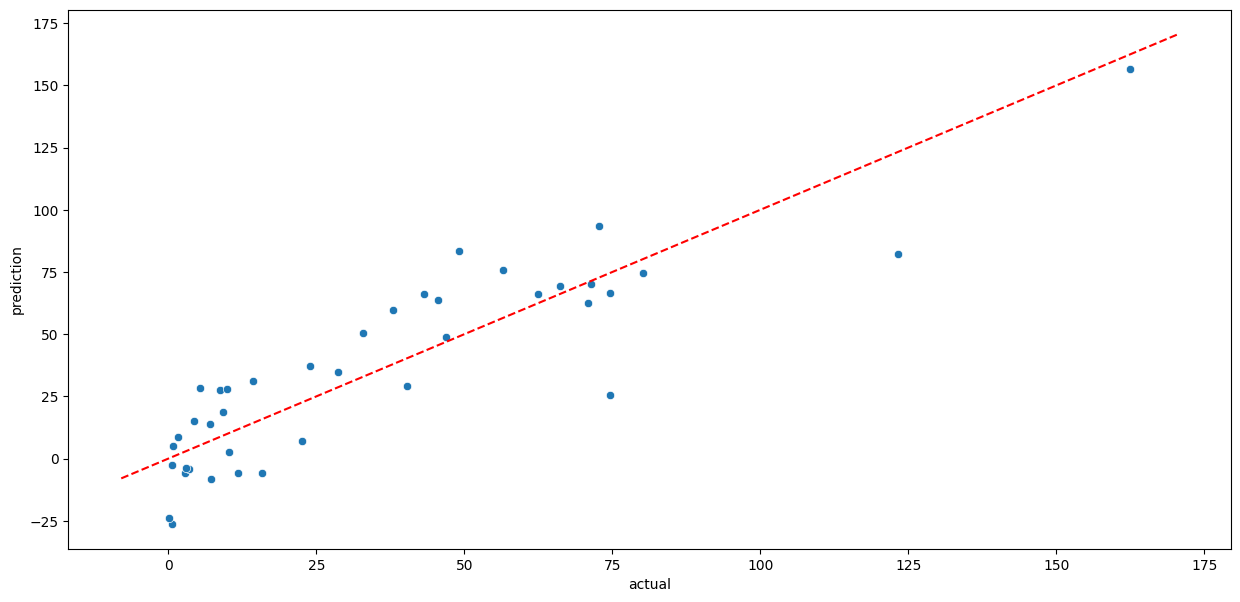

In [23]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [24]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['lr_pred']=pred
test_d.to_csv('./out/test_d.csv',index=False)

<br>

### CatBoost

In [25]:
X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
print(X_train.shape,X_test.shape)

(744, 332) (40, 332)


In [26]:
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
pbar = tqdm(kf.split(X_ref),total=10)
for tr_idx, va_idx in pbar:
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = CatBoostRegressor(iterations=5000,metric_period=1000,random_state=42,verbose=1)
    model.fit(X_tr,y_tr,eval_set=[(X_va,y_va)])
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    # tr_pred = np.exp(tr_pred)
    # va_pred = np.exp(va_pred)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

  0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.017911
0:	learn: 41.1895591	test: 40.7875493	best: 40.7875493 (0)	total: 59.5ms	remaining: 4m 57s
1000:	learn: 1.9010681	test: 6.0254338	best: 6.0254338 (1000)	total: 54s	remaining: 3m 35s
2000:	learn: 0.7337343	test: 5.7036196	best: 5.7036196 (2000)	total: 1m 39s	remaining: 2m 28s
3000:	learn: 0.3192402	test: 5.6241987	best: 5.6241987 (3000)	total: 2m 30s	remaining: 1m 40s
4000:	learn: 0.1544659	test: 5.5997171	best: 5.5997171 (4000)	total: 3m 18s	remaining: 49.7s
4999:	learn: 0.0781852	test: 5.5909930	best: 5.5909930 (4999)	total: 4m 4s	remaining: 0us

bestTest = 5.590992965
bestIteration = 4999

train : [0.0782], validation : [5.5910], test : [4.8165]
Learning rate set to 0.017911
0:	learn: 40.5462738	test: 46.4036550	best: 46.4036550 (0)	total: 85.2ms	remaining: 7m 5s
1000:	learn: 1.8477373	test: 8.6868549	best: 8.6868549 (1000)	total: 51.4s	remaining: 3m 25s
2000:	learn: 0.6281832	test: 8.2253867	best: 8.2253867 (2000)	total: 1m 38s	remaining: 2m 27s
3000:	l

In [27]:
pred = np.mean([model.predict(X_test) for model in models],axis=0) # X_test, input_df
true = y_test # y_test, label_df

np.sqrt(mean_squared_error(pred,true))

4.888612845280668

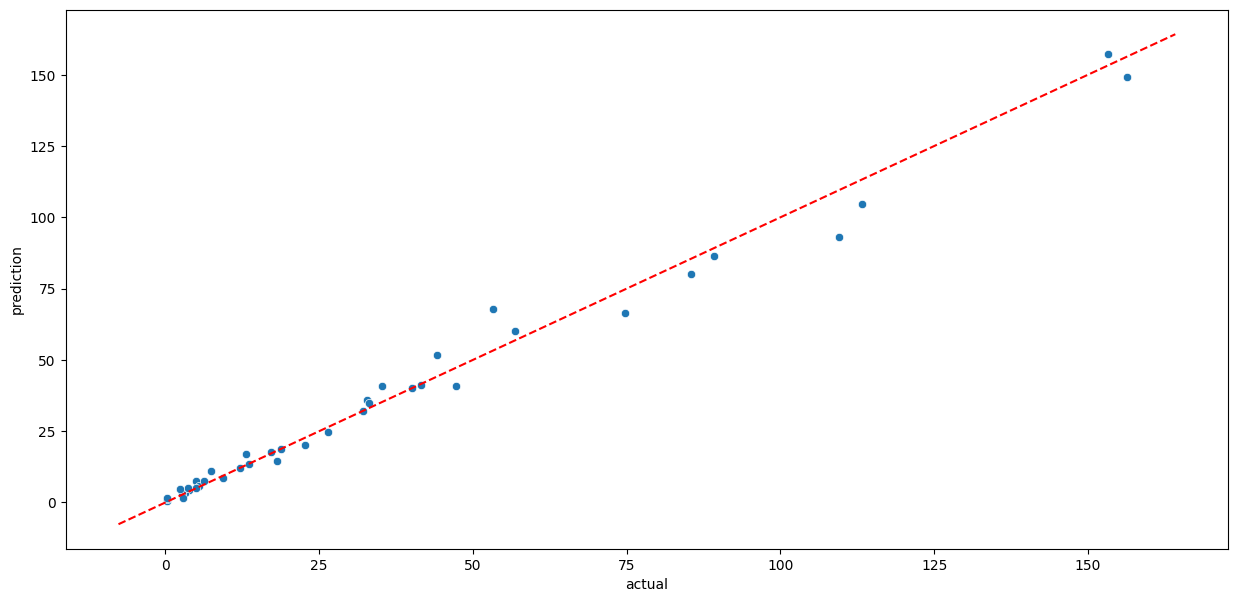

In [28]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [29]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['cat_pred']=pred
test_d.to_csv('./out/test_d.csv',index=False)

<br>

### XGBoost

In [30]:
X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
print(X_train.shape,X_test.shape)

(744, 332) (40, 332)


In [31]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
pbar = tqdm(kf.split(X_ref),total=10)
for tr_idx, va_idx in pbar:
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = XGBRegressor(n_estimators=5000,random_state=42)
    model.fit(X_tr,y_tr,eval_set=[(X_va,y_va)],verbose=0)
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

  0%|          | 0/10 [00:00<?, ?it/s]

train : [0.0008], validation : [10.0047], test : [10.0541]
train : [0.0008], validation : [13.3417], test : [10.0371]
train : [0.0007], validation : [7.9707], test : [9.9766]
train : [0.0007], validation : [9.7377], test : [11.4440]
train : [0.0007], validation : [8.7519], test : [9.1052]
train : [0.0007], validation : [10.8362], test : [9.0897]
train : [0.0007], validation : [12.3975], test : [9.9833]
train : [0.0007], validation : [11.0916], test : [9.4632]
train : [0.0008], validation : [12.9681], test : [10.6921]
train : [0.0008], validation : [11.1798], test : [8.6314]


In [32]:
pred = np.mean([model.predict(X_test) for model in models],axis=0)
true = y_test

np.sqrt(mean_squared_error(pred,true))

9.104563741693228

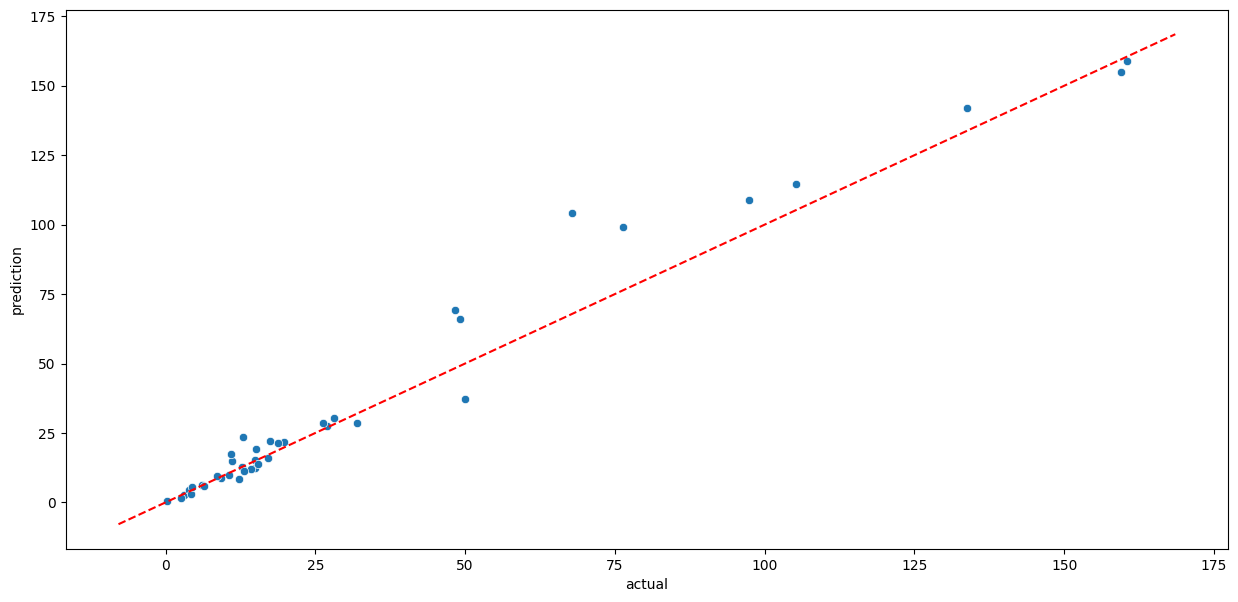

In [33]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [34]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['xgb_pred']=pred
test_d.to_csv('./out/test_d.csv',index=False)

<br>

### LightGBM

In [35]:
# X_train, X_test, y_train, y_test = train_test_split(input_df,label_df,test_size=0.05)
# print(X_train.shape,X_test.shape)

In [36]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

X_ref = X_train
y_ref = y_train

tr_preds = []
va_preds = []
te_preds = []
models = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
pbar = tqdm(kf.split(X_ref),total=10)
for tr_idx, va_idx in pbar:
    X_tr, X_va = X_ref.iloc[tr_idx,:], X_ref.iloc[va_idx,:]
    y_tr, y_va = y_ref.iloc[tr_idx]  , y_ref.iloc[va_idx]
    
    model = LGBMRegressor(n_estimators=5000,random_state=42)
    model.fit(X_tr,y_tr,eval_set=[(X_va,y_va)],verbose=0)
    models.append(model)
    
    tr_pred = model.predict(X_tr)
    va_pred = model.predict(X_va)
    te_pred = model.predict(X_test)
    
    # tr_pred = np.exp(tr_pred)
    # va_pred = np.exp(va_pred)
    
    tr_preds.append(tr_pred)
    va_preds.append(va_pred)
    te_preds.append(te_pred)
    
    tr_rmse = np.sqrt(mean_squared_error(tr_pred,y_tr))
    va_rmse = np.sqrt(mean_squared_error(va_pred,y_va))
    te_rmse = np.sqrt(mean_squared_error(te_pred,y_test))
    print('train : [{:.4f}], validation : [{:.4f}], test : [{:.4f}]'.format(tr_rmse,va_rmse,te_rmse))

  0%|          | 0/10 [00:00<?, ?it/s]

train : [0.0005], validation : [11.9749], test : [7.6208]
train : [0.0003], validation : [8.6429], test : [8.2089]
train : [0.0000], validation : [9.2471], test : [8.3211]
train : [0.0000], validation : [8.2630], test : [7.9318]
train : [0.0005], validation : [10.7937], test : [9.7457]
train : [0.0004], validation : [9.3205], test : [8.4111]
train : [0.0003], validation : [10.3799], test : [7.9830]
train : [0.0003], validation : [11.1634], test : [7.4660]
train : [0.0004], validation : [12.8893], test : [6.9463]
train : [0.0005], validation : [8.5551], test : [6.9747]


In [37]:
pred = np.mean([model.predict(X_test) for model in models],axis=0)
true = y_test

np.sqrt(mean_squared_error(pred,true))

7.406571884638592

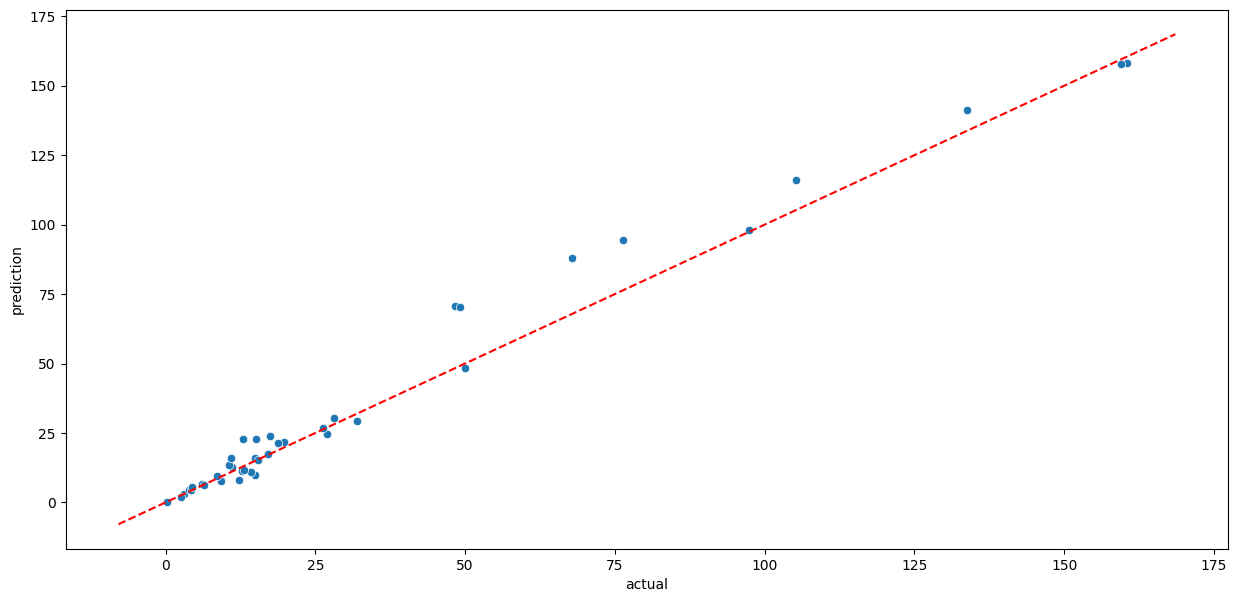

In [38]:
import seaborn as sns

plt.figure(figsize=(15,7))
sns.scatterplot(x=true,y=pred)
plt.xlabel('actual')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [39]:
pred = np.mean([model.predict(test_d[X_train.columns]) for model in models],axis=0)
test_d['lgb_pred']=pred
test_d.to_parquet('./out/test_d.parquet')

<br></br>

### Ensemble

In [40]:
os.chdir('/home/studio-lab-user/Dacon/6_상추생육환경생성/')
test_d = pd.read_parquet('./out/test_d.parqet')
test_d['case_num'] = '0'+test_d['case_num'].astype(str)

In [41]:
test_d['ensemble_pred'] = (test_d['cat_pred']+test_d['xgb_pred']+test_d['lgb_pred'])/3

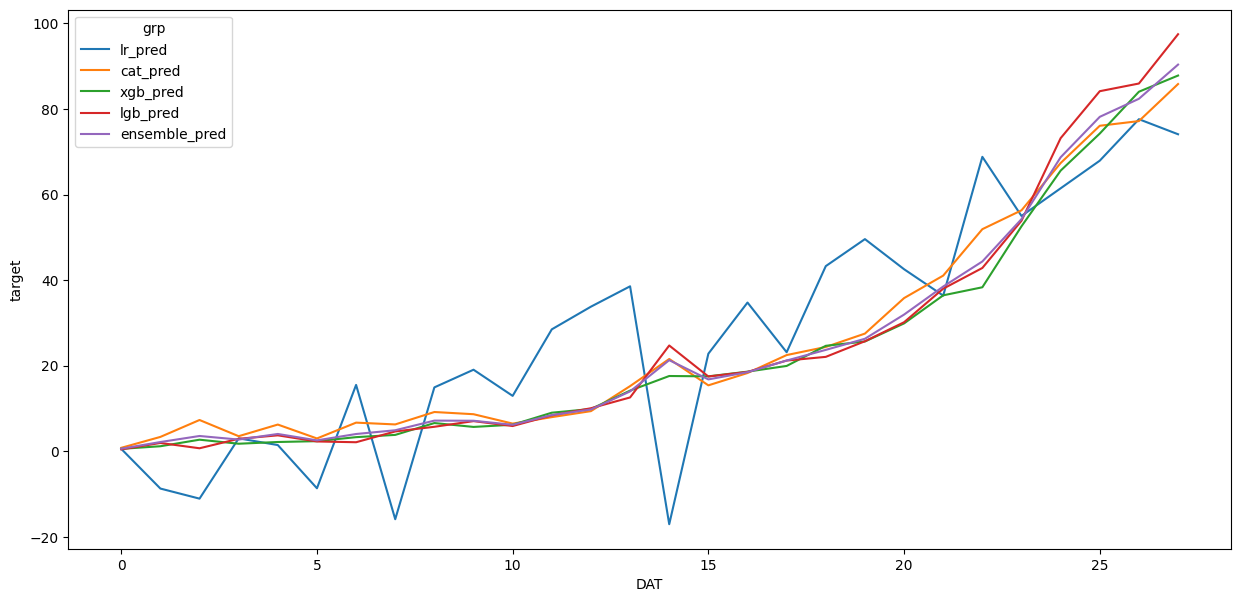

In [42]:
case_num='05'

d = test_d[test_d.case_num==case_num]

plot_df = []
for col in ['lr_pred','cat_pred','xgb_pred','lgb_pred','ensemble_pred']:
    plot_df.append(d[['DAT',col]].rename(columns={col:'target'}).assign(grp=col))
plot_df = pd.concat(plot_df,axis=0)    

plt.figure(figsize=(15,7))
sns.lineplot(x=plot_df.DAT,y=plot_df.target,hue=plot_df.grp)
plt.show()

<br></br>

# Inference

In [ ]:
test_d['predicted_weight_g'] = test_d['cat_pred']

In [ ]:
name = 'kf_ensemble'
if not os.path.exists(f'./out/{name}'):
    os.mkdir(f'./out/{name}')

test_d = test_d[['case_num','DAT','predicted_weight_g']]
for case_num in test_d.case_num.unique():
    d = test_d[test_d.case_num==case_num].drop('case_num',axis=1)
    d.to_csv(f'./out/{name}/TEST_{case_num}.csv',index=False)

In [ ]:
import zipfile
os.chdir(f"./out/{name}/")
submission = zipfile.ZipFile(f"../{name}.zip", 'w')
for path in glob.glob('./*.csv'):
    submission.write(path)
submission.close()